# **Independent Q-learning**

In [ ]:
#!pip install gymnasium numpy matplotlib tqdm dill sys

<img src="marl4.png">

In [10]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import dill
import sys

In [11]:
# Import the environment and plotting functions
sys.path.insert(0,'./env')
sys.path.insert(0,'./utils')
from env.food_collector import Food_Collector_Env
from utils.plot_results import plot_scores_epsilon

## Define QL agent

In [12]:
class QLearningAgent():

    def __init__(self, num_actions, num_states, eps_start=1.0, eps_decay=.9999, eps_min=1e-08, step_size=0.1, gamma=1):
        # Initialise agent
        self.num_actions = num_actions
        self.num_states = num_states
        self.epsilon = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.step_size = step_size
        self.gamma = gamma
        self.rand_generator = np.random.RandomState(1)
        
        # Create an array for action-value estimates and initialize it to zero.
        self.state_dict = {}
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

        
    def agent_start(self, state):

        #Update epsilon at the start of each episode
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)

        #Add state to dict if new + get index of state
        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]

        # Choose action using epsilon greedy.
        current_q = self.q[state_idx,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection

        self.prev_state_idx = self.state_dict[state]
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):

        #Add state to dict if new + get index of state
        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]

        # Choose action using epsilon greedy.
        current_q = self.q[state_idx, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Update q values
        self.q[self.prev_state_idx][self.prev_action] = (1-self.step_size) * self.q[self.prev_state_idx][self.prev_action] + \
                                                     self.step_size * (reward + self.gamma * self.q[state_idx][self.argmax(current_q)])
        
        self.prev_state_idx = self.state_dict[state]
        self.prev_action = action
        return action
    
    def agent_end(self, state, reward):
        #Add state to dict if new + get index
        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]
        
        # Perform the last q value update
        self.q[self.prev_state_idx][self.prev_action] = (1-self.step_size) * self.q[self.prev_state_idx][self.prev_action] + \
                                                    self.step_size * reward

    # Takes step in testing environment, epsilon=0 and no updates made
    def test_step(self, state):
        
        #Add state to dict if new + get index of state
        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]

        # Pick greedy action
        current_q = self.q[state_idx, :]
        action = self.argmax(current_q)

        return action

        
    def argmax(self, q_values):
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

## Train independent agents

In [13]:
def train_QL_agents(n_agents, num_episodes, max_steps_done, eps_decay, eps_min, step_size, gamma):

    # initiate environment
    env = Food_Collector_Env(grid_size=[11,11], n_agents=2)

    # get numer of states and actions from environment
    n_states = 3000000
    n_actions = env.action_space[0].n
    
    # Initialise agents
    agents = []
    for _ in range(n_agents):
        QL_agent = QLearningAgent(num_actions=n_actions, num_states=n_states,
                      eps_start = 1.0, eps_decay=eps_decay, eps_min=eps_min,
                      step_size=step_size, gamma=gamma)
        agents.append(QL_agent)

    # Monitor the scores and epsilon for each episode
    episode_rewards = [ [] for _ in range(n_agents)]
    epsilon_history = list()
    won_games = 0
    
    # for episode in num_episodes
    for episode in tqdm(range(num_episodes)):
        
        rewards_temp = [ [] for _ in range(n_agents)]
        
        # get initial state and actions
        states = env.reset()
        for i in range(len(agents)):
            action = agents[i].agent_start(states[i])
        
        rewards = [0 for _ in range(n_agents)]
        steps = 0
        
        while True:
            steps += 1
            actions = []
            for i in range(n_agents):
                action = agents[i].agent_step(rewards[i], states[i])
                actions.append(action)
            
            next_states, rewards, done, info = env.step(actions)
            
            for i in range(n_agents):
                rewards_temp[i].append(rewards[i])
            
            if done[0]:
                won_games+=1
                for i in range(n_agents):
                    agents[i].agent_end(states[i], rewards[i]) #update q values last time
                
                if episode%1000==0:
                    for i in range(n_agents):
                        episode_rewards[i].append(sum(rewards_temp[i]))
                epsilon_history.append(agents[0].epsilon)
                break
            
            if steps >= max_steps_done:
                if episode%1000==0:
                    for i in range(n_agents):
                        episode_rewards[i].append(sum(rewards_temp[i]))
                epsilon_history.append(agents[0].epsilon)
                break
                
            states = next_states
    print(f'Games won: {won_games}, in percentage: {(100*won_games/num_episodes):.2f}')
    return agents, episode_rewards, epsilon_history

In [14]:
# HYPERPARAMETERS
N_AGENTS = 2
NUM_EPISODES = 600000
EPS_DECAY = 0.9999
EPS_MIN = 0.3
STEP_SIZE = 0.1
GAMMA = 0.99
MAX_STEPS_DONE = 70

In [15]:
agents, reward_history, epsilon_history = train_QL_agents(N_AGENTS, NUM_EPISODES, MAX_STEPS_DONE, EPS_DECAY,
                                                          EPS_MIN, STEP_SIZE, GAMMA)

100%|██████████| 600000/600000 [25:41<00:00, 389.14it/s]

Games won: 501698, in percentage: 83.62


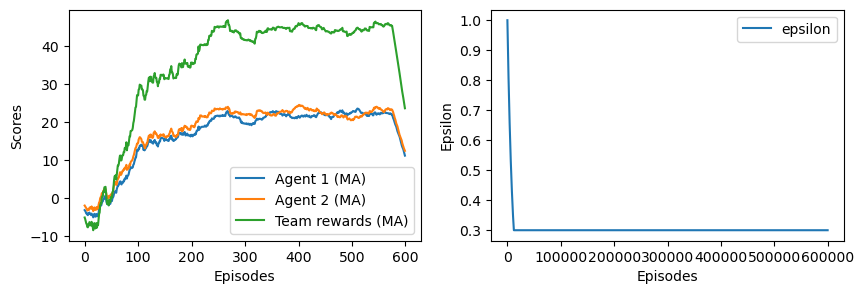

In [26]:
%matplotlib inline
plot_scores_epsilon(reward_history, epsilon_history, moving_avg_window = 50)

## Visualise agent behaviour

In [27]:
def visualise_Qlearn_agents(agents, n_episodes):
    
    n_agents = len(agents)
    env = Food_Collector_Env(grid_size=[11,11], n_agents=n_agents)

    # run n_episodes episodes
    for _ in tqdm(range(n_episodes)):
        # get initial state and actions
        states = env.reset()
        for i in range(n_agents):
            action = agents[i].agent_start(states[i])
        rewards = [0 for _ in range(n_agents)]
        step_counter = 0
        
        while True:
            step_counter += 1
            actions = []
            for i in range(n_agents):
                #action = agents[i].agent_step(rewards[i], states[i])
                action = agents[i].test_step(states[i])
                actions.append(action)
            next_states, rewards, done, info = env.step(actions)
            states = next_states
                
            env.render(frame_speed=0.01)    
            
            if done[0]:
                break
            if step_counter >= 7:
                break

  0%|          | 0/1 [00:00<?, ?it/s]

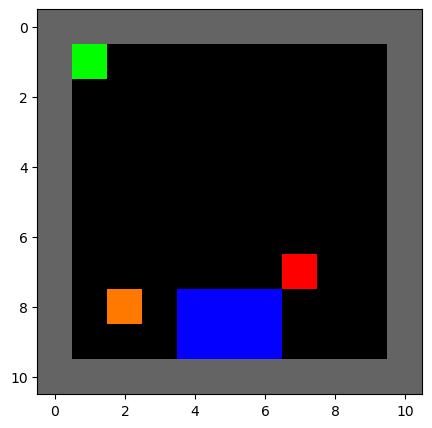

100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


In [32]:
visualise_Qlearn_agents(agents2, 1)

## Save agents

In [33]:
import dill

# Save the file
dill.dump(agents[0], file = open("trained_agents/QLagent1.pickle", "wb"))
dill.dump(agents[1], file = open("trained_agents/QLagent2.pickle", "wb"))

In [34]:
a1 = dill.load(open("trained_agents/QLagent1.pickle", "rb"))
a2 = dill.load(open("trained_agents/QLagent2.pickle", "rb"))

agents2 = [a1,a2]